In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from ML.DTGenerated import DTGenerated
import pickle

In [13]:
from generateTestingData.useGeneratedData import makeDataUsable, splitTrainTest, NewPredicter

In [14]:
MODEL_PREFIX = "gen"
SAVE_MODELS = False 
PI = 4 # past importance
RBC = 5 # rows before col

In [15]:
df = makeDataUsable(read_csv("../data/generatedData.csv"), PI, RBC)
print(df.shape)
df.head()

(3950, 30)


,Time,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,...,asX4,asY1,asY2,asY3,asY4,asZ1,asZ2,asZ3,asZ4,COL
0,3.0,50.0,50.0,50.0,50.000,16.6264,100.0,100.0,100.0000,0.004,...,0.000,0.000,-0.000,-0.001,-0.001,0.000,0.006,0.001,0.000,0.0
1,4.0,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.661,...,-0.001,-0.000,-0.001,-0.001,0.000,0.006,0.001,0.000,-0.001,0.0
2,5.0,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,4.117,...,-0.000,-0.001,-0.001,0.000,0.000,0.001,0.000,-0.001,0.000,0.0
3,6.0,50.0,50.0,50.0,50.000,100.0000,100.0,100.0,100.0000,0.865,...,0.000,-0.001,0.000,0.000,0.000,0.000,-0.001,0.000,0.000,0.0
4,7.0,50.0,50.0,50.0,5.322,100.0000,100.0,100.0,83.3296,3.704,...,0.004,0.000,0.000,0.000,-0.001,-0.001,0.000,0.000,0.005,0.0


In [16]:
df["COL"].value_counts()

COL
0.0    3458
1.0     492
Name: count, dtype: int64

In [17]:
sampleSize = int(len(df[df['COL'] == 1]) * 1.05)
df = pd.concat([df[df["COL"] == False].sample(sampleSize, random_state=1), df[df["COL"] == True]])

In [18]:
data = df.copy().drop(columns=df.columns[0], axis=1)
trainX, trainY, testX, testY = splitTrainTest(data)

Splitting at 806, total rows: 1008


In [19]:
trainX.head(3)

,TTC1,TTC2,TTC3,TTC4,DTO1,DTO2,DTO3,DTO4,JERK1,JERK2,...,asX3,asX4,asY1,asY2,asY3,asY4,asZ1,asZ2,asZ3,asZ4
3534,50.000,50.0,2.244,1.911,73.3941,16.2252,13.1836,10.4597,0.476,5.264,...,-0.003,-0.004,-0.0,-0.017,-0.229,-0.000,0.012,-0.022,0.01,0.004
3575,50.000,50.0,50.000,0.256,34.7847,100.0000,30.5879,10.3737,0.096,0.012,...,-0.000,0.000,-0.0,0.000,0.000,0.000,0.005,0.000,0.00,-0.000
411,22.961,50.0,13.351,50.000,42.6613,59.3565,55.2873,100.0000,0.386,0.006,...,-0.000,-0.027,0.0,0.000,0.000,-0.134,-0.000,-0.000,0.00,0.011


## Model

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### MLP Classifier

In [21]:
mlp_clf = NewPredicter()
mlp_trainX = mlp_clf.preProcess(trainX.copy())
mlp_testX = mlp_clf.preProcess(testX.copy())

mlp_trainY, mlp_testY = trainY.to_numpy(), testY.to_numpy()

mlp_clf.fit(mlp_trainX, mlp_trainY)

Scaler is fitted


In [22]:
mlp_pred = mlp_clf.predict(mlp_testX)
mlp_score = mlp_clf.getScore(mlp_pred, mlp_testY)

Total: 202, Collisions: 82
Accuracy: 0.7574257425742574, Precision: 0.6666666666666666, Recall: 0.8048780487804879, F1: 0.7292817679558011
Confusion matrix:
[[87 33]
 [16 66]]


In [23]:
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(mlp_testY, mlp_pred)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

In [24]:
model_score = f"{mlp_score[0][0]}-{mlp_score[0][1]}-{mlp_score[1][0]}-{mlp_score[1][1]}"

if SAVE_MODELS:
    mlp_clf.saveModel(f"MLPClassifier_{MODEL_PREFIX}_PI{PI}_RBC{RBC}", accuracy=model_score)

### Random Forest Classifier

In [25]:
rf_clf = NewPredicter(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1))
rf_trainX = rf_clf.preProcess(trainX.copy())
rf_testX = rf_clf.preProcess(testX.copy())

rf_trainY, rf_testY = trainY.to_numpy(), testY.to_numpy()

rf_clf.fit(rf_trainX, rf_trainY)

Scaler is fitted


In [26]:
rf_pred = rf_clf.predict(rf_testX)
rf_score = rf_clf.getScore(rf_pred, rf_testY)

Total: 202, Collisions: 84
Accuracy: 0.7475247524752475, Precision: 0.6666666666666666, Recall: 0.7857142857142857, F1: 0.721311475409836
Confusion matrix:
[[85 33]
 [18 66]]


In [27]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(rf_testY, rf_pred)
rf_roc_auc = auc(rf_fpr, rf_tpr)

In [28]:
model_score = f"{rf_score[0][0]}-{rf_score[0][1]}-{rf_score[1][0]}-{rf_score[1][1]}"

if SAVE_MODELS:
    rf_clf.saveModel(f"RandomForestClassifier_{MODEL_PREFIX}_PI{PI}_RBC{RBC}", accuracy=model_score)

### SVM Classifier

In [29]:
svm_clf = NewPredicter(SVC(random_state=1))
svm_trainX = svm_clf.preProcess(trainX.copy())
svm_testX = svm_clf.preProcess(testX.copy())

svm_trainY, svm_testY = trainY.to_numpy(), testY.to_numpy()

svm_clf.fit(svm_trainX, svm_trainY)

Scaler is fitted


In [30]:
svm_pred = svm_clf.predict(svm_testX)
svm_score = svm_clf.getScore(svm_pred, svm_testY)

Total: 202, Collisions: 83
Accuracy: 0.7623762376237624, Precision: 0.6767676767676768, Recall: 0.8072289156626506, F1: 0.7362637362637363
Confusion matrix:
[[87 32]
 [16 67]]


In [31]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(svm_testY, svm_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)

In [32]:
model_score = f"{svm_score[0][0]}-{svm_score[0][1]}-{svm_score[1][0]}-{svm_score[1][1]}"

if SAVE_MODELS:
    svm_clf.saveModel(f"SVC_{MODEL_PREFIX}_PI{PI}_RBC{RBC}", accuracy=model_score)

### XGBoost Classifier

In [33]:
xgb_clf = NewPredicter(XGBClassifier(n_estimators=100, random_state=1))
xgb_trainX = xgb_clf.preProcess(trainX.copy())
xgb_testX = xgb_clf.preProcess(testX.copy())

xgb_trainY, xgb_testY = trainY.to_numpy(), testY.to_numpy()

Scaler is fitted


In [34]:
xgb_clf.fit(xgb_trainX, xgb_trainY)

In [35]:
xgb_pred = xgb_clf.predict(xgb_testX)
xgb_score = xgb_clf.getScore(xgb_testY, xgb_pred)

Total: 202, Collisions: 99
Accuracy: 0.7425742574257426, Precision: 0.7640449438202247, Recall: 0.6868686868686869, F1: 0.7234042553191489
Confusion matrix:
[[82 21]
 [31 68]]


In [36]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(xgb_testY, xgb_pred)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

In [37]:
# model_score = f"{score[0][0]}-{score[0][1]}-{score[1][0]}-{score[1][1]}"
model_score = f"{xgb_score[0][0]}-{xgb_score[0][1]}-{xgb_score[1][0]}-{xgb_score[1][1]}"

if SAVE_MODELS:
    xgb_clf.saveModel(f"XGBClassifier_{MODEL_PREFIX}_PI{PI}_RBC{RBC}", accuracy=model_score)

---

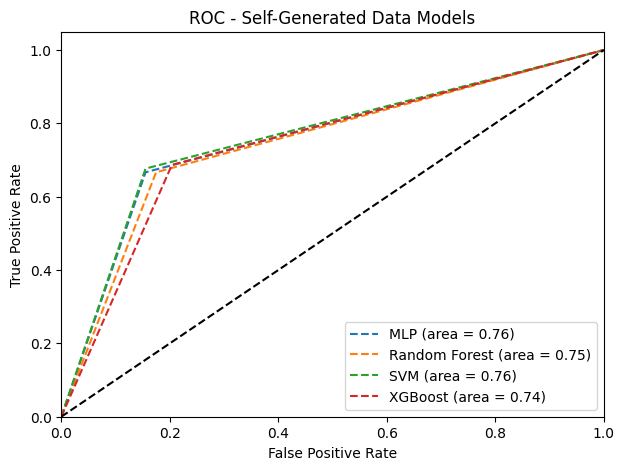

In [40]:
plt.figure(figsize=(7, 5))
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP (area = {mlp_roc_auc:.2f})", linestyle="dashed")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (area = {rf_roc_auc:.2f})", linestyle="dashed")
plt.plot(svm_fpr, svm_tpr, label=f"SVM (area = {svm_roc_auc:.2f})", linestyle="dashed")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (area = {xgb_roc_auc:.2f})", linestyle="dashed")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC - Self-Generated Data Models")
plt.legend(loc="lower right")
plt.show()